In [1]:
!python --version

Python 3.10.12


In [2]:
!nvidia-smi #show the allocated GPU

Fri Oct 27 05:22:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

# Import Library

In [3]:
import matplotlib.pyplot as plt
import tensorflow

import numpy as np # linear algebra
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, precision_score, roc_curve, auc
from sklearn.model_selection import KFold
import random
import sys
import pandas
import pandas as pd #
import seaborn as sns 
import os
import gc

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Model,load_model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load Dataset

In [4]:
train_dir = '/kaggle/input/fer2013plus/fer2013plus/fer2013/train'
test_dir = '/kaggle/input/fer2013plus/fer2013plus/fer2013/test'
emotion = os.listdir(train_dir)
emotion

['surprise',
 'fear',
 'neutral',
 'sadness',
 'disgust',
 'contempt',
 'happiness',
 'anger']

# Generate image and augmentation

In [5]:
input_tensor  = Input(shape=(48,48,3))
img_size      = (48, 48)
batch_size    = 32  
epochs    = 100
learning_rate = 0.0001

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=0.3, #5,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   #zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode='nearest',
                                   validation_split = 0.2,)


train_generator = train_datagen.flow_from_directory(
        train_dir,  # training data directory
        target_size=img_size,  
        batch_size=batch_size,
        shuffle=True,
        # because it is a classification problem more 2 classes then use class_mode = 'categorical'
        class_mode='categorical',
        subset='training') # set as training data
 
validation_generator = train_datagen.flow_from_directory(
        train_dir, # validation data directory
        target_size=img_size, 
        batch_size=batch_size,
        shuffle=False,
        # because it is a classification problem more 2 classes then use class_mode = 'categorical'
        class_mode='categorical',
        subset='validation') # set as validation data

Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.


# Explore some training data

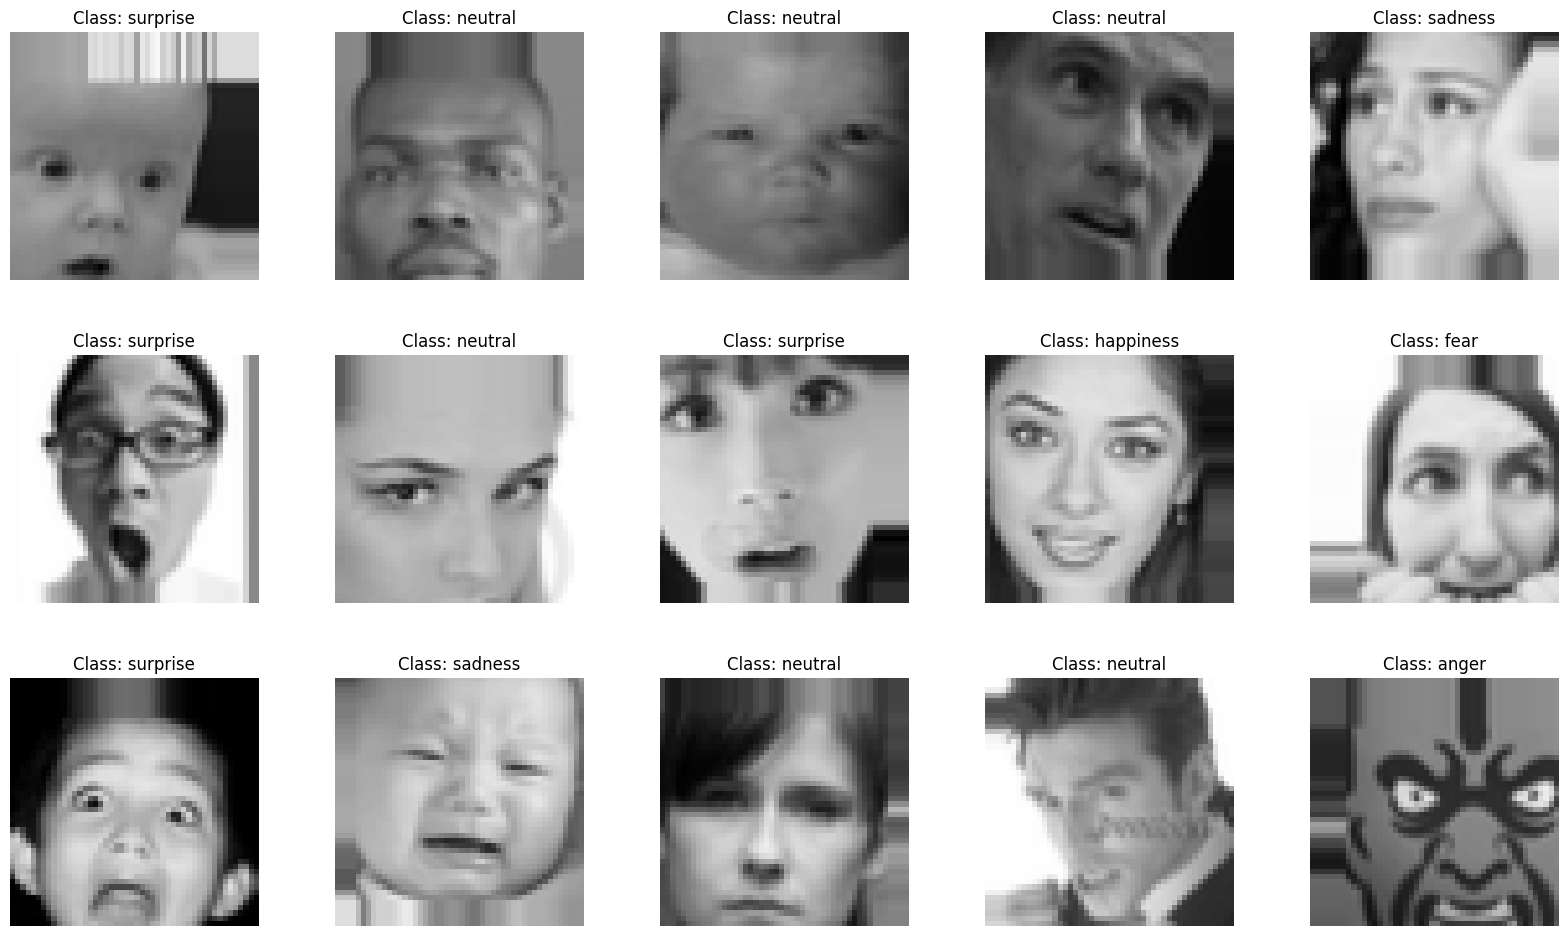

In [6]:
labels = [k for k in train_generator.class_indices]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

In [7]:
num_classes = 8

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3)),
    tf.keras.layers.MaxPool2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Add dropout for regularization

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Add dropout for regularization

    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 256)        0

In [8]:
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
file_name = 'best_model.h5'
checkpoint_path= os.path.join('checkpoint',file_name)


call_back = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                        monitor='val_accuracy',
                                        verbose=1,
                                        save_freq='epoch',
                                        save_best_only=True,
                                        save_weights_only=False,
                                        mode='max'),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    #tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=10,
                                  verbose=1,factor=0.2, min_lr=0.000001)
]

In [10]:
# fit model
steps_per_epoch=train_generator.n/batch_size
validation_steps=validation_generator.n/batch_size

history = model.fit(
              train_generator, 
              steps_per_epoch=steps_per_epoch,  # how many batches will be executed in each epoch
              epochs=epochs,
              validation_data=validation_generator, # displays the accuracy of validation data testing
              validation_steps=validation_steps,  # how many batches will be executed in each epoch
              callbacks=call_back,
              verbose=1)

Epoch 1/100
710/709 [==============================] - ETA: 0s - loss: 1.6990 - accuracy: 0.3354
Epoch 1: val_accuracy improved from -inf to 0.36324, saving model to checkpoint/best_model.h5
709/709 [==============================] - 68s 87ms/step - loss: 1.6990 - accuracy: 0.3354 - val_loss: 1.5950 - val_accuracy: 0.3632 - lr: 1.0000e-04
Epoch 2/100
710/709 [==============================] - ETA: 0s - loss: 1.6188 - accuracy: 0.3551
Epoch 2: val_accuracy improved from 0.36324 to 0.37381, saving model to checkpoint/best_model.h5
709/709 [==============================] - 61s 86ms/step - loss: 1.6188 - accuracy: 0.3551 - val_loss: 1.5660 - val_accuracy: 0.3738 - lr: 1.0000e-04
Epoch 3/100
710/709 [==============================] - ETA: 0s - loss: 1.5872 - accuracy: 0.3672
Epoch 3: val_accuracy improved from 0.37381 to 0.38791, saving model to checkpoint/best_model.h5
709/709 [==============================] - 62s 87ms/step - loss: 1.5872 - accuracy: 0.3672 - val_loss: 1.5366 - val_accur

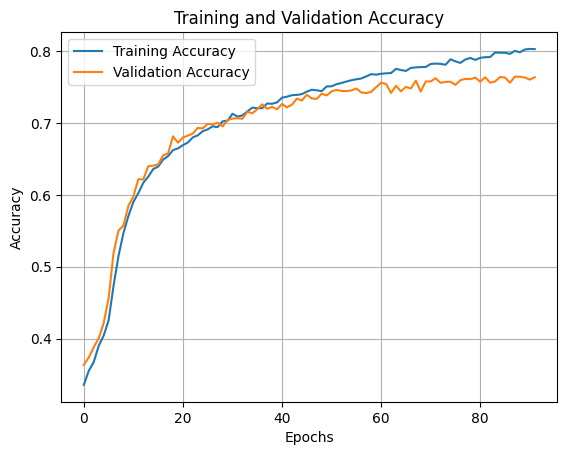

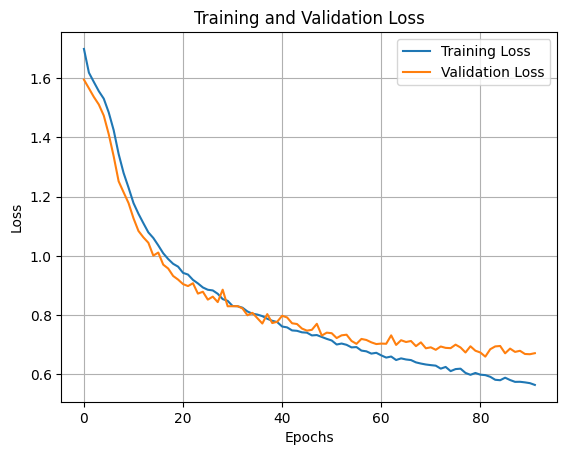

In [11]:
# Plot Model Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Model Loss
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plt.plot(epochs, loss_train,  label='Training Loss')
plt.plot(epochs, loss_val, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Found 7099 images belonging to 8 classes.
221/221 [==============================] - 43s 193ms/step
[[ 491    0    0    7   18   92   14   22]
 [   6    0    1    0    1   35    6    2]
 [  38    0    1    1    0    6    9    2]
 [   8    0    0   72    2   20   10   55]
 [  44    0    0    5 1598  109   33   38]
 [  64    0    0    8   85 2210  168   62]
 [  42    0    0   11   27  305  463    8]
 [  28    0    0   20   16   65    4  767]]


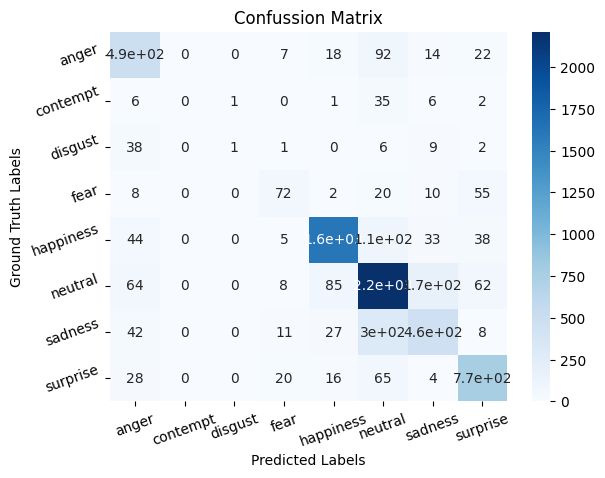

<Figure size 300x300 with 0 Axes>


              ---Classification Report---

              precision    recall  f1-score   support

       anger     0.6810    0.7624    0.7194       644
    contempt     0.0000    0.0000    0.0000        51
     disgust     0.5000    0.0175    0.0339        57
        fear     0.5806    0.4311    0.4948       167
   happiness     0.9147    0.8747    0.8942      1827
     neutral     0.7776    0.8510    0.8126      2597
     sadness     0.6549    0.5409    0.5925       856
    surprise     0.8023    0.8522    0.8265       900

    accuracy                         0.7891      7099
   macro avg     0.6139    0.5412    0.5468      7099
weighted avg     0.7800    0.7891    0.7808      7099



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# Rescale
img_size      = (48, 48)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size=(48, 48), 
                 batch_size=batch_size,
                 class_mode=None,
                 shuffle=False)
test_steps=test_generator.n/batch_size
test_generator.reset()

#Calling the saved model for making predictions
model_file='/kaggle/working/checkpoint/best_model.h5'
tl_img_aug_cnn = load_model(model_file)
pred=tl_img_aug_cnn.predict(test_generator,
                            verbose=1,
                            steps=test_steps)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results_test.csv",index=False)
target_names=list(validation_generator.class_indices.keys())
test_labels = [fn.split('/')[0] for fn in filenames]
cm=confusion_matrix(test_labels,predictions)
print(cm)

    
#Confussion Matrix Figure
fig = sns.heatmap(cm, annot=True, cmap = "Blues")
fig.set(title = 'Confussion Matrix', xlabel='Predicted Labels', ylabel='Ground Truth Labels')
fig.set_xticklabels(target_names,rotation=20)
fig.set_yticklabels(target_names,rotation=20)
plt.figure(figsize=(3,3))
plt.show(fig)

#Classification Report
cr=classification_report(test_labels, predictions, digits=4)
print("\n              ---Classification Report---\n")
print(cr)